### LSTM for Stock Price Prediction - First Attempt

In [22]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [44]:
# 1. Load stock price data and feature engineering
ticker = "COST"
data = yf.download(ticker, start="2018-01-01", end=datetime.datetime.today().strftime('%Y-%m-%d'))

def add_indicators(df):
    df["SMA_50"] = df["Close"].rolling(window=50).mean()  # 50-day SMA
    df["EMA_50"] = df["Close"].ewm(span=50, adjust=False).mean()  # 50-day EMA

    # Relative Strength Index (RSI)
    delta = df["Close"].diff(1)
    gain = np.where(delta > 0, delta, 0).flatten()
    loss = np.where(delta < 0, -delta, 0).flatten()
    avg_gain = pd.Series(gain, index=df.index).rolling(window=14, min_periods=1).mean()
    avg_loss = pd.Series(loss, index=df.index).rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # MACD (12-day EMA - 26-day EMA)
    df["MACD"] = df["Close"].ewm(span=12, adjust=False).mean() - df["Close"].ewm(span=26, adjust=False).mean()

    # Bollinger Bands (20-day)
    df["BB_Upper"] = df["Close"].rolling(window=20).mean() + (df["Close"].rolling(window=20).std() * 2)
    df["BB_Lower"] = df["Close"].rolling(window=20).mean() - (df["Close"].rolling(window=20).std() * 2)

    return df

data = add_indicators(data)
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [45]:
# 2. Normalize the data

features = ["Close", "SMA_50", "EMA_50", "RSI", "MACD", "BB_Upper", "BB_Lower"]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

In [46]:
# 3. Prepare the training data

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)
X_train, y_train = X[:-200], y[:-200]   # all but last 200 days for training
X_test, y_test = X[-200:], y[-200:]     # last 200 days for testing

In [47]:
# 4. Build the LSTM Model

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")

c:\Users\Simon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
# 5. Train the model

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0251 - val_loss: 0.0304
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0020 - val_loss: 0.0084
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0016 - val_loss: 0.0054
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014 - val_loss: 7.7676e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0011 - val_loss: 7.2559e-04
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0010 - val_loss: 7.8098e-04
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.6498e-04 - val_loss: 0.0061
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 9.8449e-04 - val_loss: 6.7561e-04
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 

In [49]:
# 6. Make predictions

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.hstack([predictions] + [np.zeros((predictions.shape[0], len(features) - 1))]))[:,0]

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


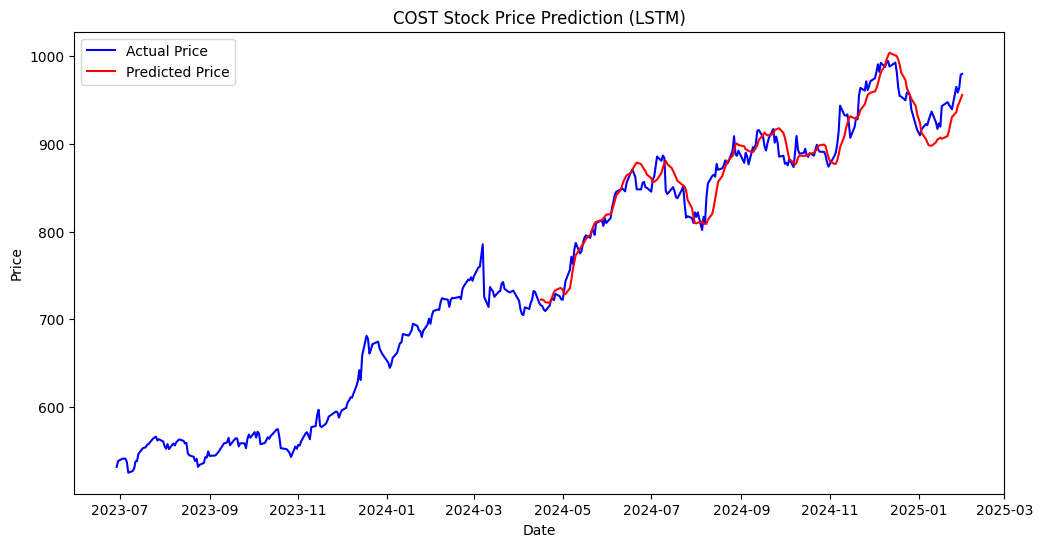

In [50]:
# 7. Visualize results

plt.figure(figsize=(12, 6))
plt.plot(data.index[-400:], data["Close"].values[-400:], label="Actual Price", color="blue")
plt.plot(data.index[-200:], predictions, label="Predicted Price", color="red")
plt.title(f"{ticker} Stock Price Prediction (LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()



plt.show()

In [52]:
print(data.index[-200:])

DatetimeIndex(['2024-04-16 00:00:00+00:00', '2024-04-17 00:00:00+00:00',
               '2024-04-18 00:00:00+00:00', '2024-04-19 00:00:00+00:00',
               '2024-04-22 00:00:00+00:00', '2024-04-23 00:00:00+00:00',
               '2024-04-24 00:00:00+00:00', '2024-04-25 00:00:00+00:00',
               '2024-04-26 00:00:00+00:00', '2024-04-29 00:00:00+00:00',
               ...
               '2025-01-17 00:00:00+00:00', '2025-01-21 00:00:00+00:00',
               '2025-01-22 00:00:00+00:00', '2025-01-23 00:00:00+00:00',
               '2025-01-24 00:00:00+00:00', '2025-01-27 00:00:00+00:00',
               '2025-01-28 00:00:00+00:00', '2025-01-29 00:00:00+00:00',
               '2025-01-30 00:00:00+00:00', '2025-01-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=200, freq=None)
